In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.irf import load_cta_irfs
from gammapy.maps import WcsGeom, MapAxis
from regions import CircleSkyRegion
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    GaussianSpatialModel,
    SkyModel,
    Models,
    PointSpatialModel,
    FoVBackgroundModel,
)
from gammapy.makers import MapDatasetMaker, SafeMaskMaker, RingBackgroundMaker
from gammapy.modeling import Fit
from gammapy.maps import Map
from scipy.stats import norm
from gammapy.data import Observation
from gammapy.datasets import MapDataset, MapDatasetOnOff
from gammapy.estimators import ExcessMapEstimator

In [3]:
import scipy.stats as stats
import math
import statistics
import os

In [4]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [5]:
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


In [6]:
# Define the observation parameters (typically the observation duration and the pointing position):
livetime = 1.0 * u.hr
pointing = SkyCoord(141.409467, 40.566962, unit="deg", frame="galactic")

In [7]:
# Define map geometry for binned simulation
energy_reco = MapAxis.from_edges(
    np.logspace(-1.0, 1.0, 10), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(141.409467, 40.566962),
    binsz=0.02,
    width=(3, 3),
    frame="galactic",
    axes=[energy_reco],
)
# It is usually useful to have a separate binning for the true energy axis
energy_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 30), unit="TeV", name="energy_true", interp="log"
)

In [8]:
# Define sky model to used simulate the data.
# Here we use a Gaussian spatial model and a Power Law spectral model.
spatial_model = PointSpatialModel(
    lon_0="141.409467 deg", lat_0="40.566962 deg", frame="galactic"
)
spectral_model = PowerLawSpectralModel(
    index=2.22, amplitude="1.289e-12 cm-2 s-1 TeV-1", reference="1 TeV"
)
model_simu = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model,
    name="model-simu",
)

In [9]:
# Create an in-memory observation
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Observation

	obs id            : 0 
 	tstart            : 51544.00
	tstop             : 51544.04
	duration          : 3600.00 s
	pointing (icrs)   : 149.0 deg, 69.7 deg

	deadtime fraction : 0.0%



In [10]:
# Make the MapDataset
empty = MapDataset.create(geom, name="dataset-simu")
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])

maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=3.5 * u.deg)

dataset = maker.run(empty, obs)
dataset = maker_safe_mask.run(dataset, obs)
print(dataset)

MapDataset
----------

  Name                            : dataset-simu 

  Total counts                    : nan 
  Total background counts         : 27108.70
  Total excess counts             : nan

  Predicted counts                : 27108.70
  Predicted background counts     : 27108.70
  Predicted excess counts         : nan

  Exposure min                    : 5.12e+08 m2 s
  Exposure max                    : 1.30e+10 m2 s

  Number of total bins            : 0 
  Number of fit bins              : 202500 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




In [11]:
# Add the model on the dataset and Poission fluctuate
dataset.models = model_simu#models
dataset.fake(random_state=2)
# Do a print on the dataset - there is now a counts maps
print(dataset)

MapDataset
----------

  Name                            : dataset-simu 

  Total counts                    : 27326 
  Total background counts         : 27108.70
  Total excess counts             : 217.30

  Predicted counts                : 27341.10
  Predicted background counts     : 27108.70
  Predicted excess counts         : 232.40

  Exposure min                    : 5.12e+08 m2 s
  Exposure max                    : 1.30e+10 m2 s

  Number of total bins            : 202500 
  Number of fit bins              : 202500 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 116986.31

  Number of models                : 1 
  Number of parameters            : 5
  Number of free parameters       : 4

  Component 0: SkyModel
  
    Name                      : model-simu
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : 
    Parameters:
      

In [12]:
# To plot, eg, counts:
dataset.counts.smooth(0.05 * u.deg).plot_interactive(
    add_cbar=True, stretch="linear"
)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

In [13]:
dataset.background.smooth(0.05 * u.deg).plot_interactive(
    add_cbar=True, stretch="linear"
)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

In [14]:
dataset.excess.smooth(0.05 * u.deg).plot_interactive(
    add_cbar=True, stretch="linear"
)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

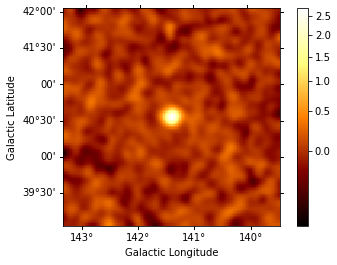

In [15]:
excess = dataset.excess.sum_over_axes()
excess.smooth("0.06 deg").plot(stretch="sqrt", add_cbar=True);

In [16]:
source_pos = SkyCoord(141.409467, 40.566962, unit="deg", frame="galactic")

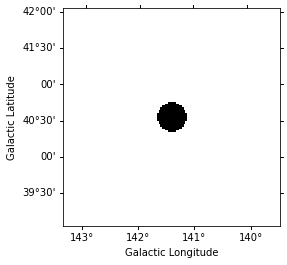

In [17]:
geom_image = geom.to_image().to_cube([energy_reco.squash()])

regions = CircleSkyRegion(center=source_pos, radius=0.2 * u.deg)
exclusion_mask = Map.from_geom(geom_image)
exclusion_mask.data = geom_image.region_mask([regions], inside=False)
exclusion_mask.sum_over_axes().plot();

In [18]:
ring_maker = RingBackgroundMaker(
    r_in="0.5 deg", width="0.3 deg", exclusion_mask=exclusion_mask
)

In [19]:
dataset_on_off = MapDatasetOnOff.create(
    geom=geom_image, energy_axis_true=energy_true, name="stacked"
)

dataset_on_off = ring_maker.run(dataset.to_image())

In [20]:
print(dataset_on_off)

MapDatasetOnOff
---------------

  Name                            : SAAiP6ww 

  Total counts                    : 27326 
  Total background counts         : 27079.16
  Total excess counts             : 246.84

  Predicted counts                : 27079.25
  Predicted background counts     : 27079.25
  Predicted excess counts         : nan

  Exposure min                    : 5.12e+08 m2 s
  Exposure max                    : 1.30e+10 m2 s

  Number of total bins            : 22500 
  Number of fit bins              : 22500 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 26246.55

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 60726244 
  Acceptance                      : 27109 
  Acceptance off                  : 60735960 



In [21]:
# Using a convolution radius of 0.04 degrees
estimator = ExcessMapEstimator(0.04 * u.deg, selection_optional=[])
lima_maps = estimator.run(dataset_on_off)

In [22]:
significance_map = lima_maps["sqrt_ts"]
excess_map = lima_maps["excess"]

(<Figure size 720x720 with 4 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7f65357475c0>)

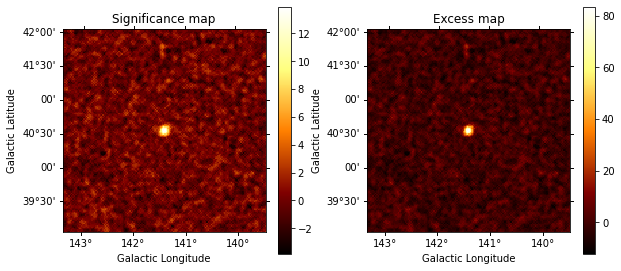

In [23]:
# We can plot the excess and significance maps
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(221, projection=significance_map.geom.wcs)
ax2 = plt.subplot(222, projection=excess_map.geom.wcs)

ax1.set_title("Significance map")
significance_map.plot(ax=ax1, add_cbar=True)

ax2.set_title("Excess map")
excess_map.plot(ax=ax2, add_cbar=True)

In [24]:
dataset_on_off.models = model_simu
print(dataset_on_off)

MapDatasetOnOff
---------------

  Name                            : SAAiP6ww 

  Total counts                    : 27326 
  Total background counts         : 27079.16
  Total excess counts             : 246.84

  Predicted counts                : 27311.56
  Predicted background counts     : 27079.16
  Predicted excess counts         : 232.40

  Exposure min                    : 5.12e+08 m2 s
  Exposure max                    : 1.30e+10 m2 s

  Number of total bins            : 22500 
  Number of fit bins              : 22500 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 25867.61

  Number of models                : 1 
  Number of parameters            : 5
  Number of free parameters       : 4

  Component 0: SkyModel
  
    Name                      : model-simu
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : 
    Parameters:
  

In [25]:
%%time
fit = Fit([dataset_on_off])
result = fit.run(optimize_opts={"print_level": 1})

------------------------------------------------------------------
| FCN = 2.587E+04               |      Ncalls=94 (94 total)      |
| EDM = 6.13E-05 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
CPU times: user 5.35 s, sys: 97 ms, total: 5.44 s
Wall time: 5.42 s


In [26]:
print(result)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 94
	total stat : 25866.24



In [27]:
result.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,float64
index,2.1730e+00,,nan,nan,False,1.818e-01
amplitude,1.4344e-12,cm-2 s-1 TeV-1,nan,nan,False,1.560e-13
reference,1.0000e+00,TeV,nan,nan,True,0.000e+00
lon_0,1.4141e+02,deg,nan,nan,False,5.090e-03
lat_0,4.0567e+01,deg,-9.000e+01,9.000e+01,False,3.797e-03
